# 0.0. IMPORTS

In [93]:
import math
import numpy as np
import pandas as pd
import inflection
import datetime

import seaborn as sns

from matplotlib import pyplot as plt 
from matplotlib.gridspec import GridSpec
from IPython.display import Image

plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

## 0.1. Helper functions

## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv( '/home/judson/Downloads/comunidade-ds/ds-em-producao/data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '/home/judson/Downloads/comunidade-ds/ds-em-producao/data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DESCRICAO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 
            'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print( f'Number of Rows: {df1.shape[0]}')
print( f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [9]:
# competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month  
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year  
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo2_since_week   
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# promo2_since_year               
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval    
month_map = { 1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'Mai', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [10]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
  
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [13]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


In [14]:
# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/home/judson/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance'>

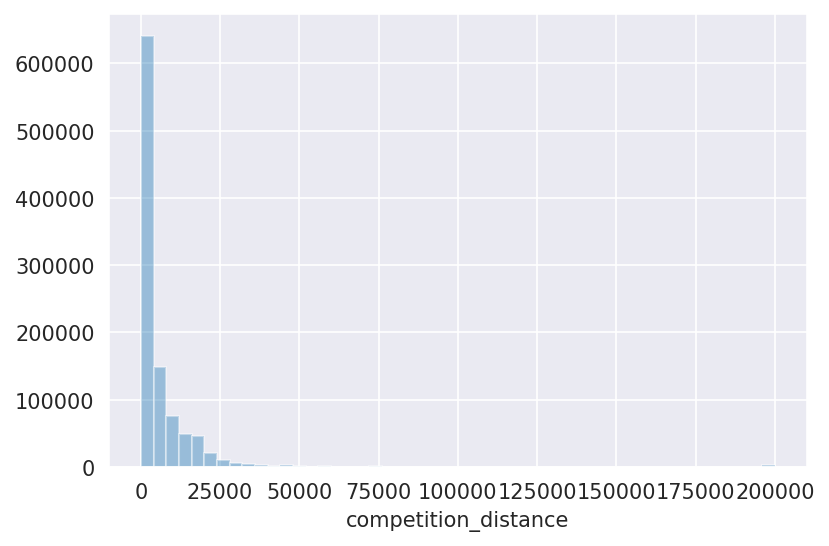

In [15]:
sns.distplot( df1['competition_distance'], kde=False )

### 1.7.2. Categorical Attributes

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

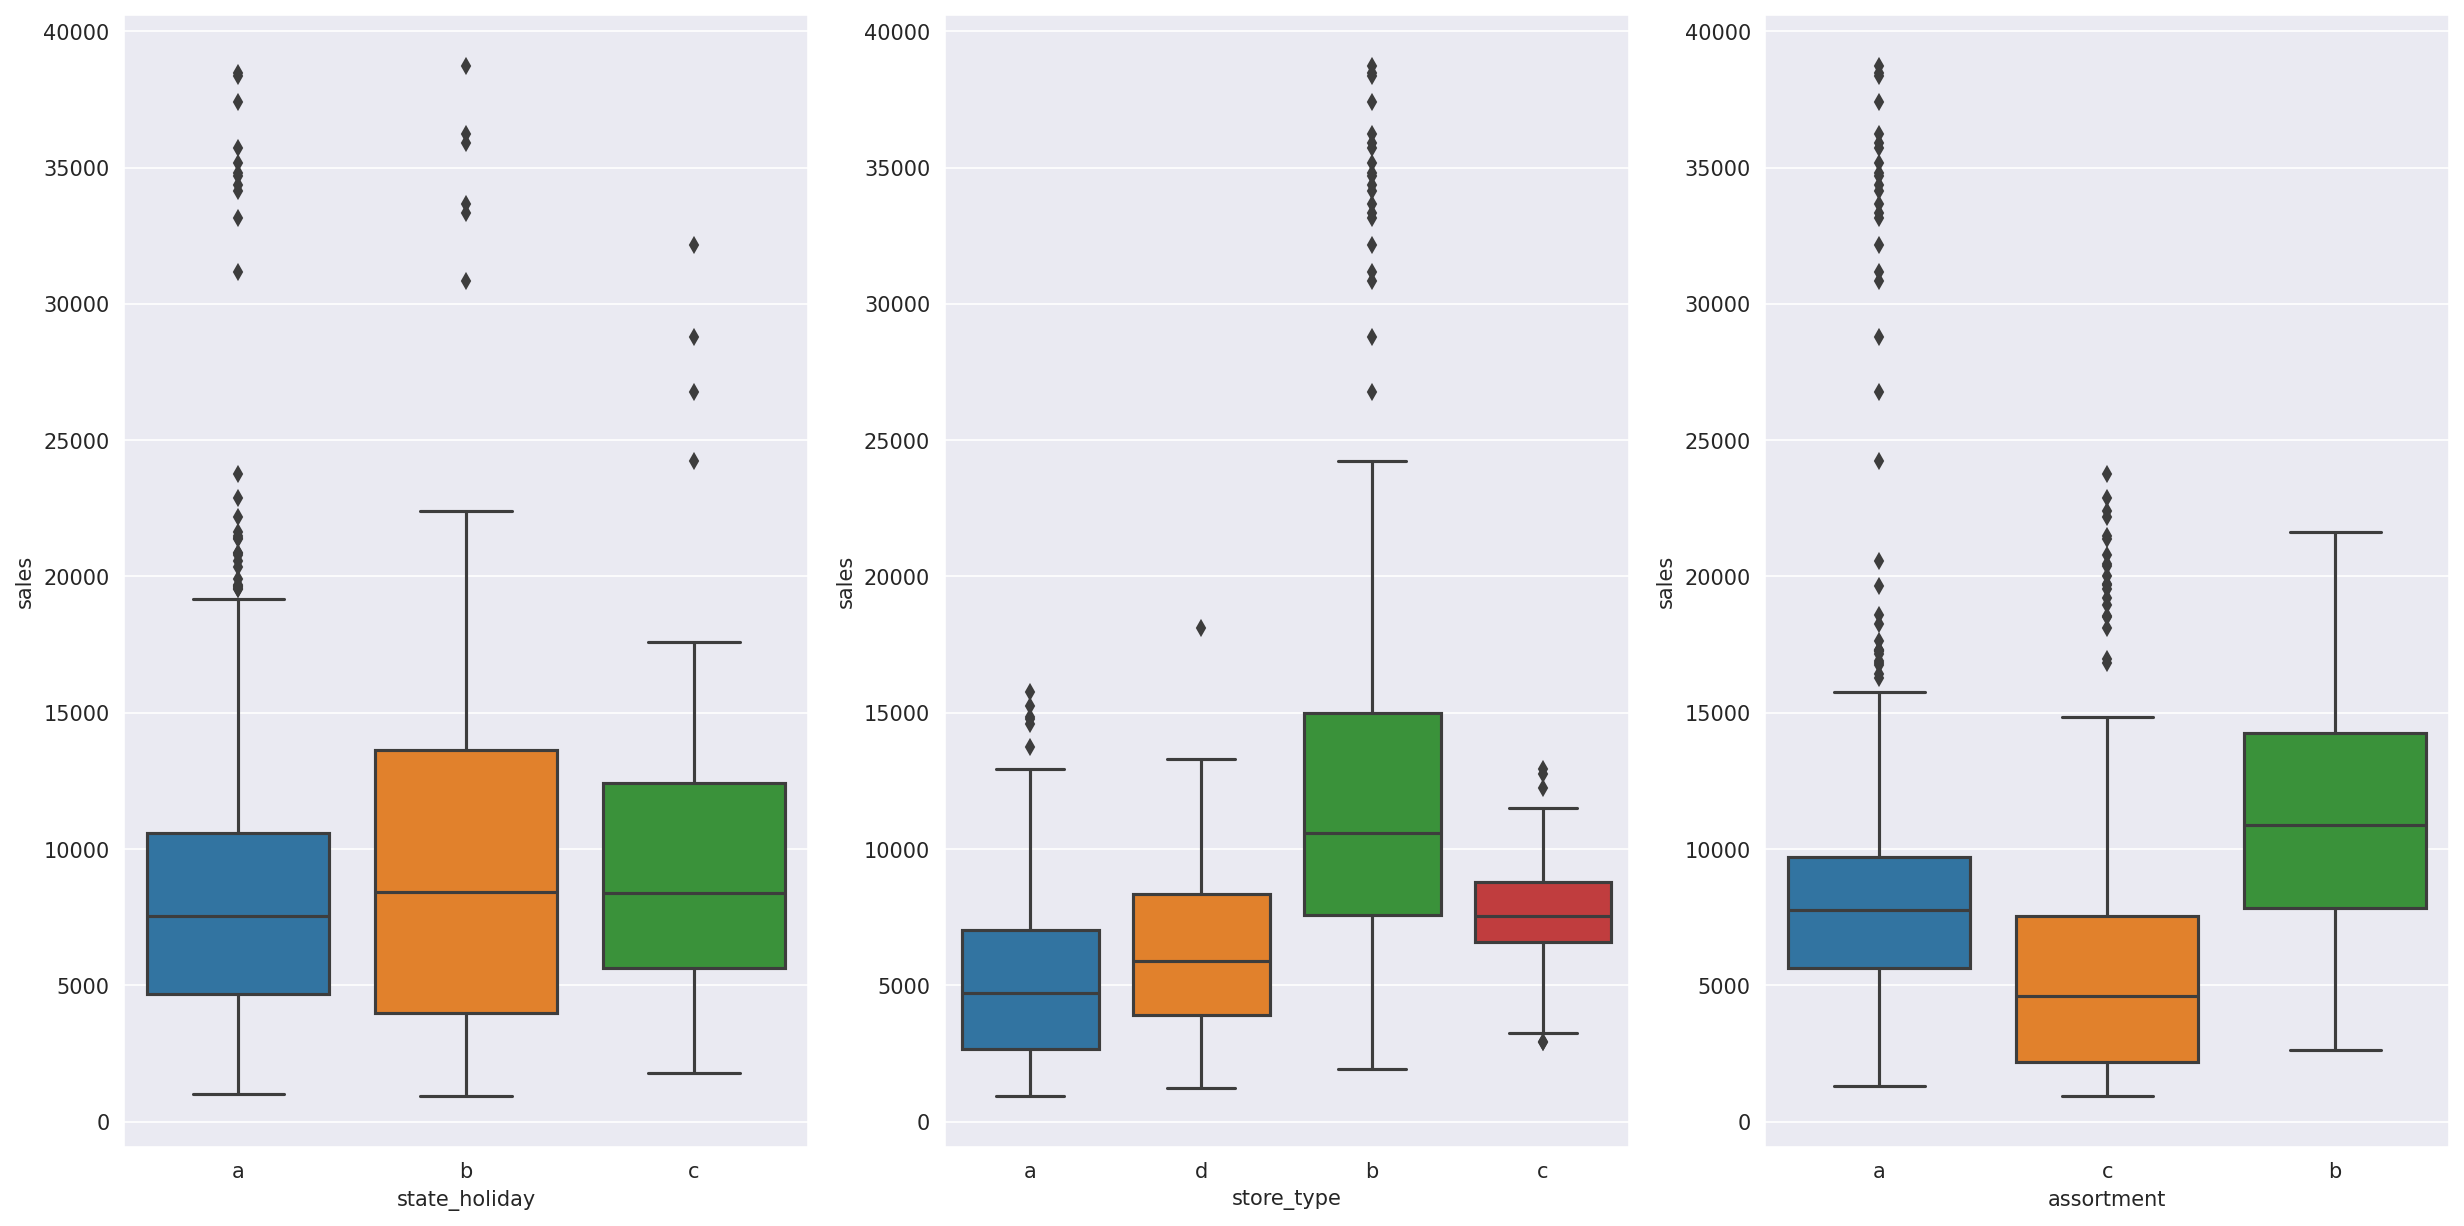

In [17]:
aux1 = df1[(df1['state_holiday'] !='0') & (df1['sales']>0)]

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday' , y='sales' , data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type' , y='sales' , data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment' , y='sales' , data=aux1 )
# outlier no boxplot é três vezes o desvio padrão

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

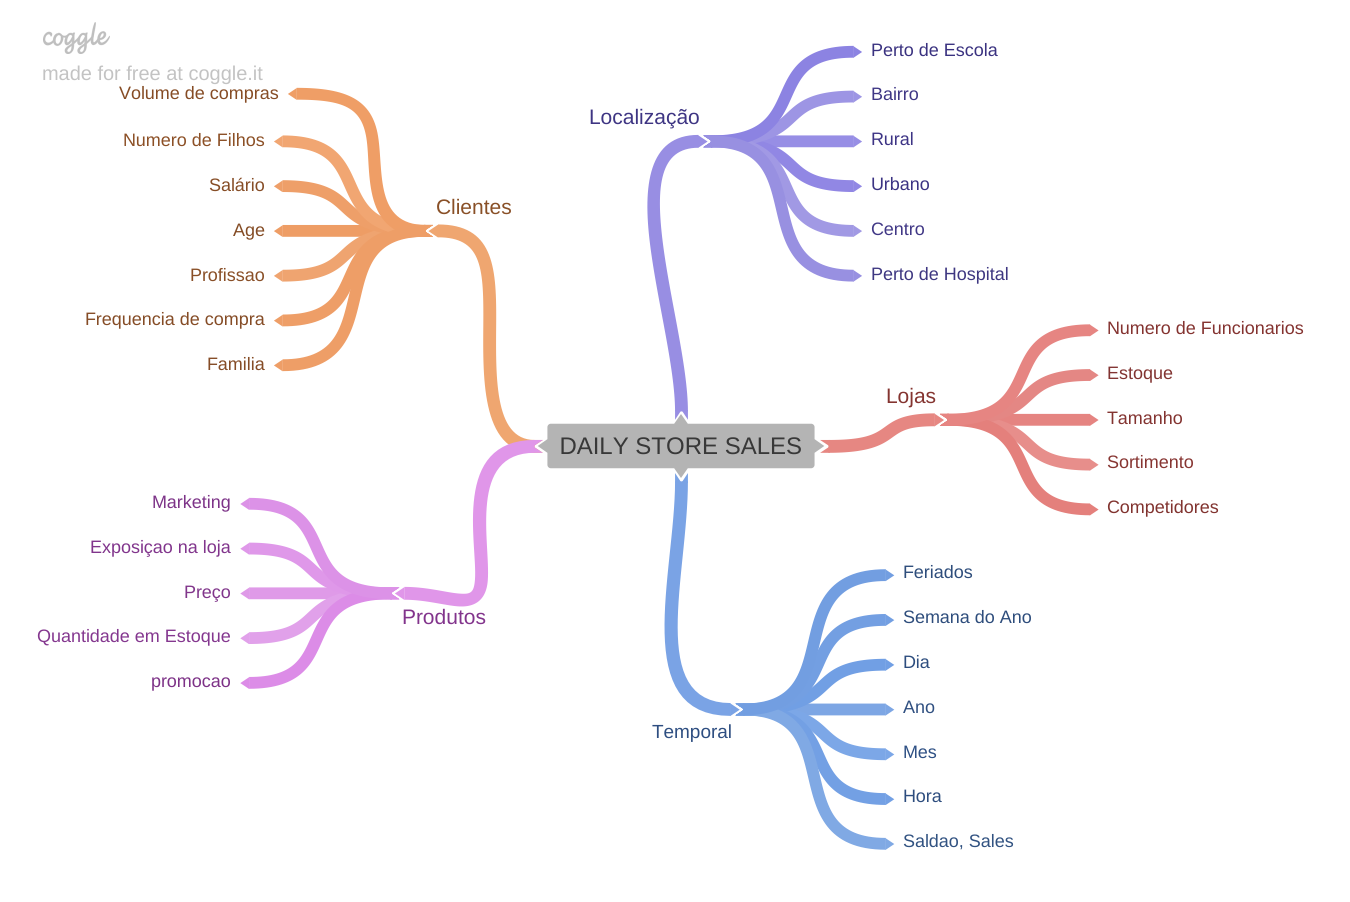

In [19]:
Image( '/home/judson/Downloads/comunidade-ds/ds-em-producao/img/MindMapHypothesis.png' )

## 2.2. Criação das Hipóteses

### 2.2.1. Hipoteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais;

**2.** Lojas com maior capacidade de estoque deveriam vender mais;

**3.** Lojas com maior porte deveriam vender mais;

**4.** Lojas com menor porte deveriam vender menos;

**5.** Lojas com maior sortimento deveriam vender mais;

**6.** Lojas com competidores mais próximos deveriam vender menos;

**7.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais;

**2.** Lojas com maior exposição de produtos nas vitrines deveriam vender mais;

**3.** Lojas com produtos com preços menores deveriam vender mais;

**4.** Lojas com promoções mais agressivas ( desconto maiores ), deveriam vender mais;

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais;

**6.** Lojas com mais dias de promoção deveriam vender mais;

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

**1-** Lojas abertas durante o feriado de Natal deveriam vender mais;

**2-** Lojas deveriam vender mais ao longo dos anos;

**3-** Lojas deveriam vender mais no segundo semestre do ano;

**4-** Lojas deveriam vender mais depois do dia 10 de cada mês;

**5.** Lojas deveriam vender menos aos finais de semana;

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

#### - O único critério, que funciona muito bem, é se você tem o dado disponível naquele momento ou não...

**1.** Lojas com maior sortimento deveriam vender mais;

**2.** Lojas com competidores mais próximos deveriam vender menos;

**3.** Lojas com competidores à mais tempo deveriam vender mais. 

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais;

**5.** Lojas com mais dias de promoção deveriam vender mais;

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7-** Lojas abertas durante o feriado de Natal deveriam vender mais;

**8-** Lojas deveriam vender mais ao longo dos anos;

**9-** Lojas deveriam vender mais no segundo semestre do ano;

**10-** Lojas deveriam vender mais depois do dia 10 de cada mês;

**11.** Lojas deveriam vender menos aos finais de semana;

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [21]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [22]:
df3 = df2.copy()

In [23]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [24]:
# Com a loja fechada não temos vendas, logo não aprendemos nada com essas linhas
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Seleção das Colunas

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map'] # restrição de negócio pois não tenho ela no momento da previsão (coluna customer nesse caso)
df3 = df3.drop( cols_drop, axis=1 )

In [26]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [27]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Variavel resposta

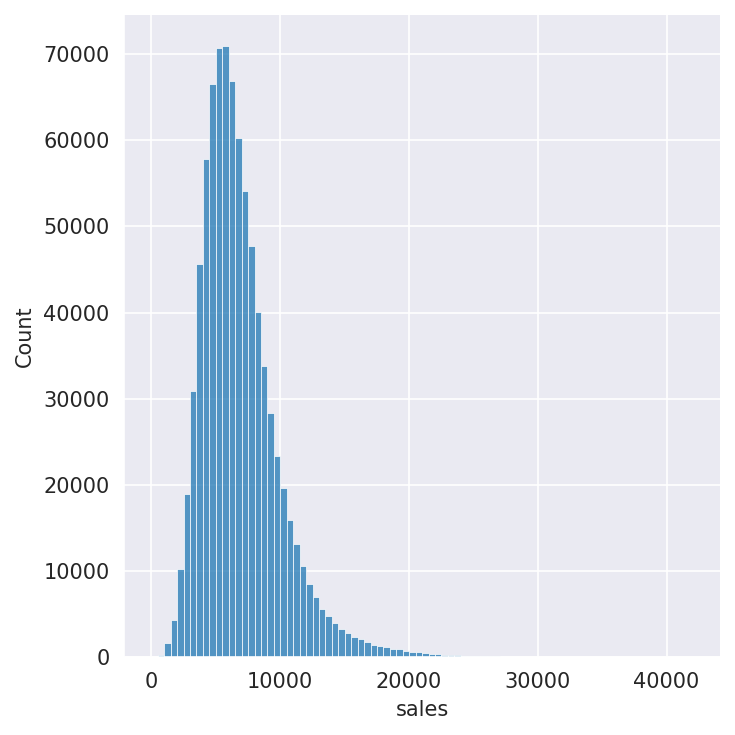

In [28]:
sns.displot( df4['sales'], binwidth=500 )

### 4.1.2. Variavel numerica

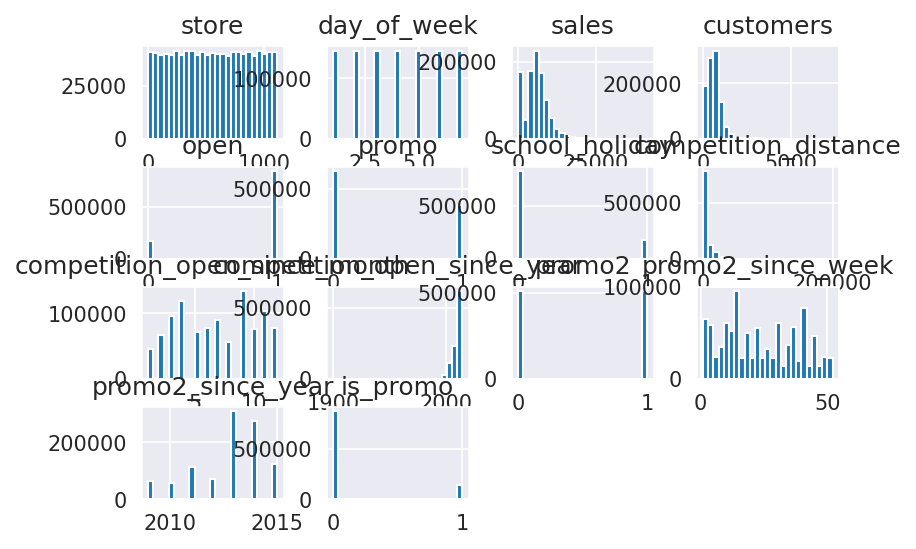

In [29]:
num_attributes.hist( bins=25 );

### 4.1.3. Variavel categorica

In [30]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/home/judson/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/judson/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/judson/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

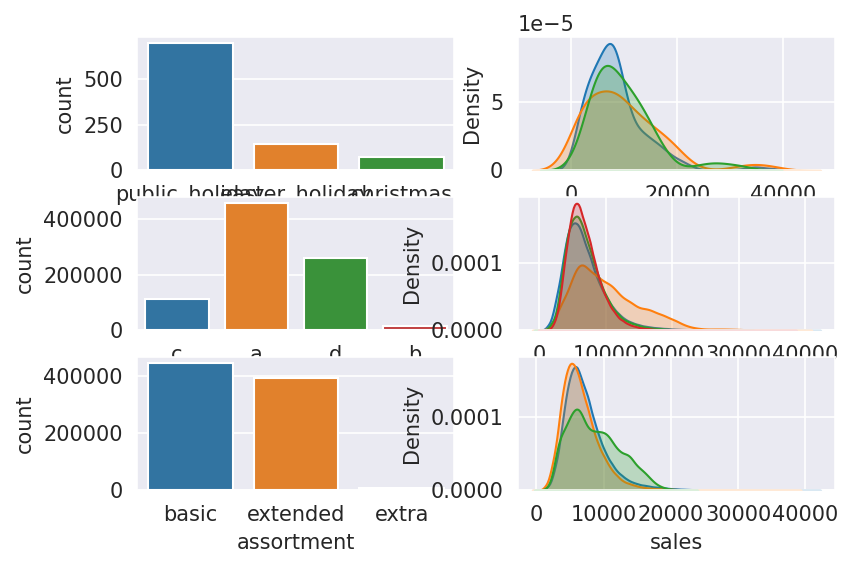

In [31]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot(3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot(3, 2, 3)
sns.countplot( df3['store_type'] )

plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot(3, 2, 5)
sns.countplot( df3['assortment'] )

plt.subplot(3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )


## 4.2. Analise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

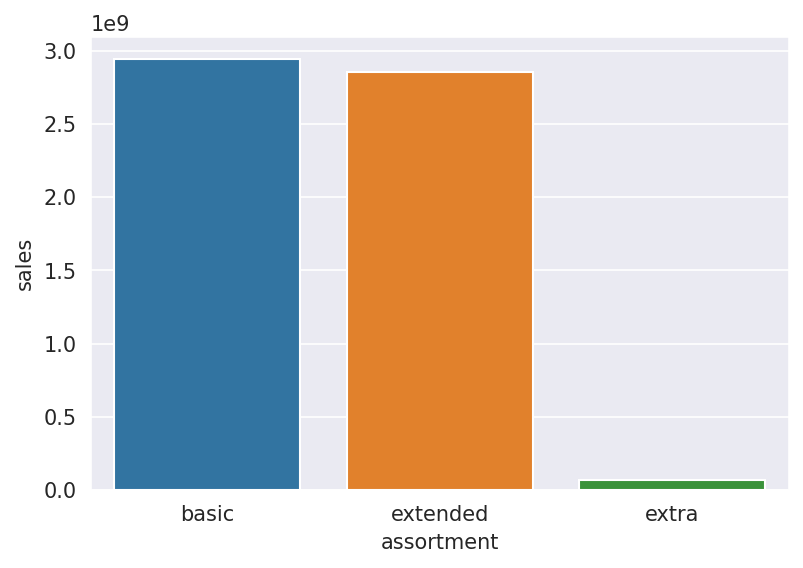

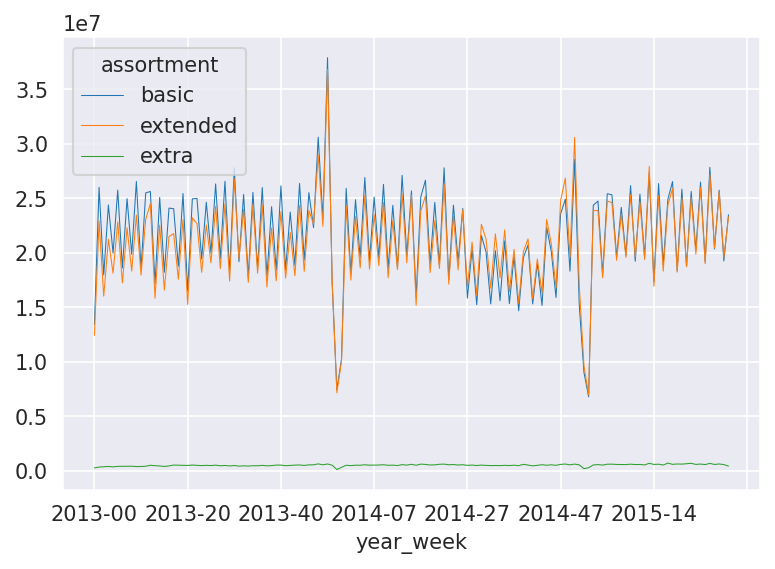

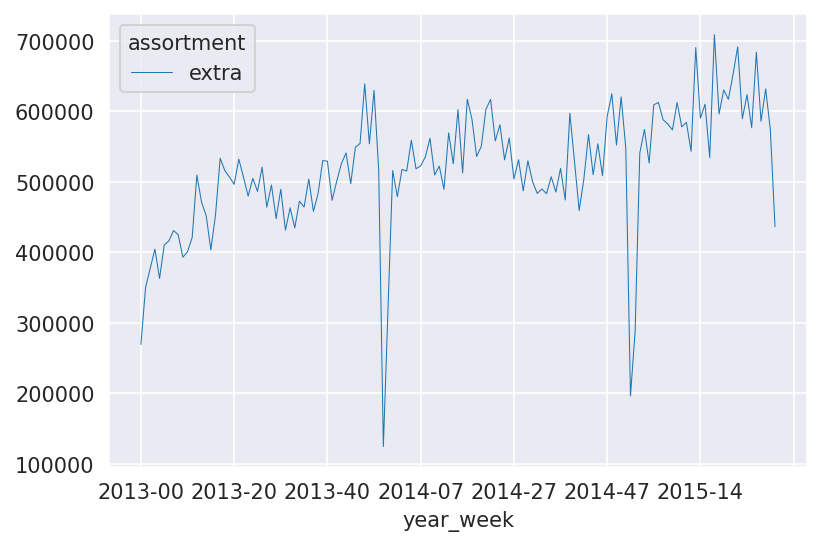

In [52]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot(lw=0.5)

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot(lw=0.5)


In [47]:
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


### H2. Lojas com competidores mais próximos deveriam vender menos
**FALSA** Lojas com competidores mais próximos vendem MAIS.

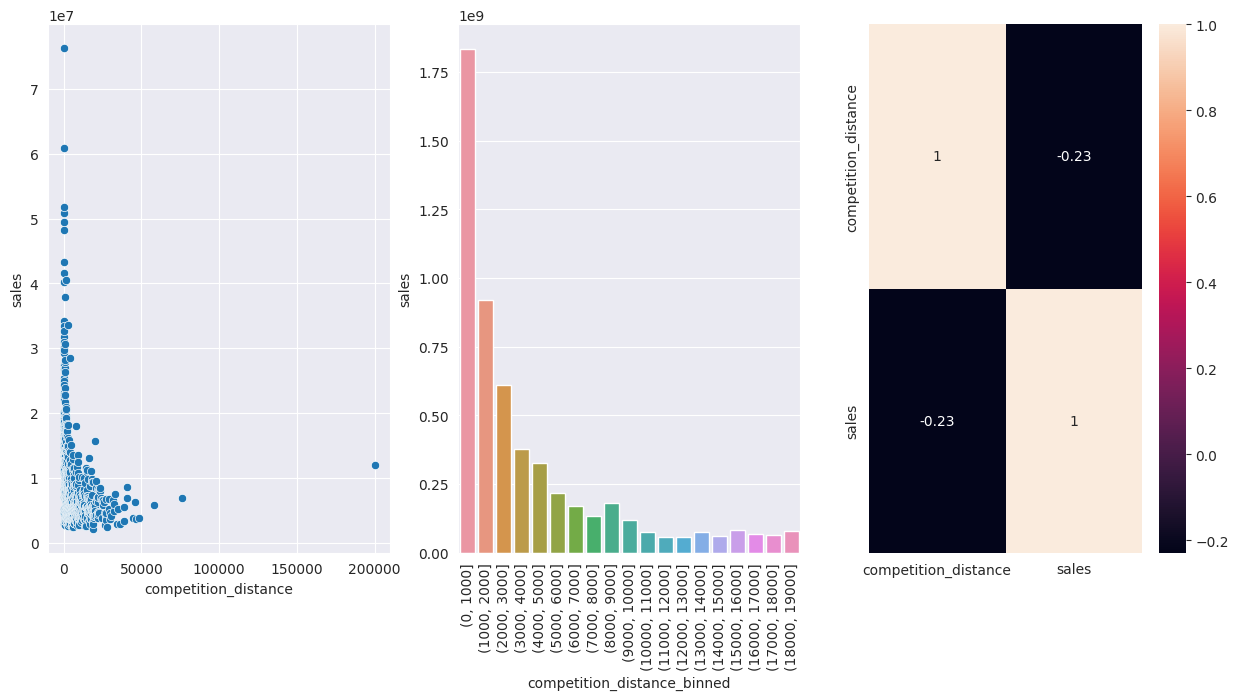

In [83]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

f = plt.figure(figsize=(15,7))
ax = f.add_subplot(131)
sns.scatterplot( x = 'competition_distance', y='sales', data=aux1 );


ax2 = f.add_subplot(132)
bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

ax3 = f.add_subplot(133)
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );


### H3. Lojas com competidores à mais tempo deveriam vender mais
**FALSA** Lojas com competidores à mais tempo vendem MENOS.

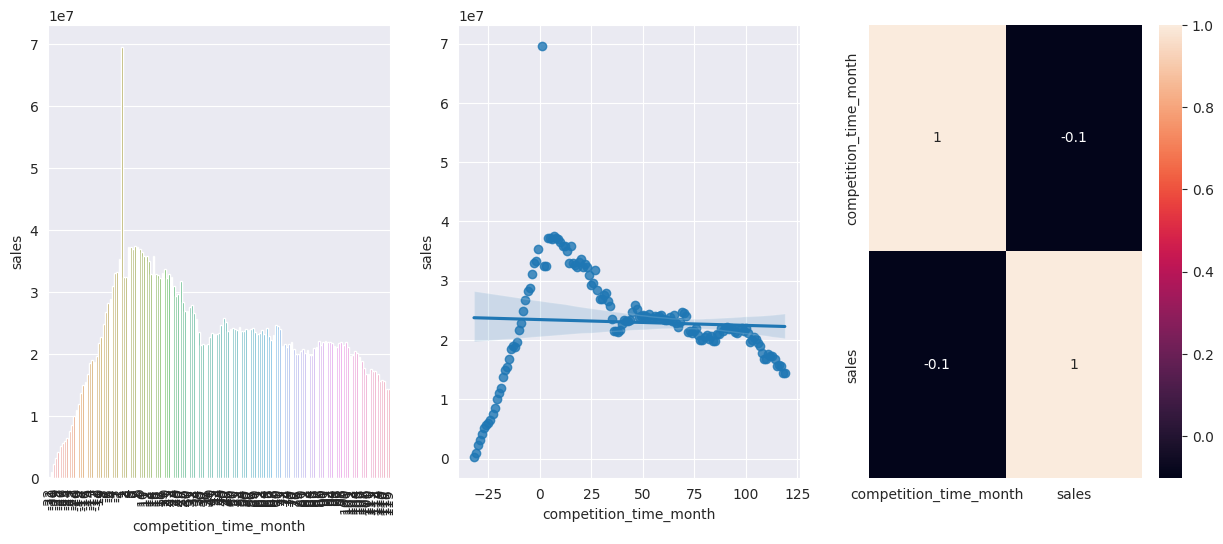

In [82]:
f = plt.figure(figsize=(15, 6))
ax = f.add_subplot(131)
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90);

ax2 = f.add_subplot(132)
sns.regplot( x='competition_time_month', y='sales', data=aux2 )

ax3 = f.add_subplot(133)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção 

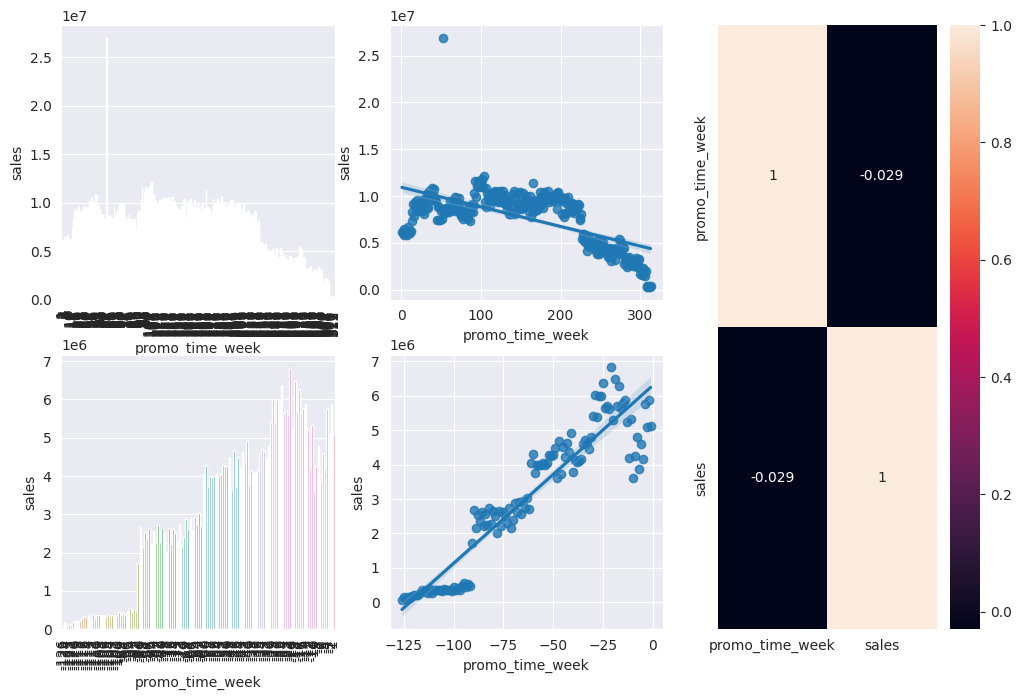

In [96]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

fig = plt.figure(figsize=(12, 8))
grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90);

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );


plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90);


plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:, 2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>H5. Lojas com mais dias de promoção deveriam vender mais</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos

In [103]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


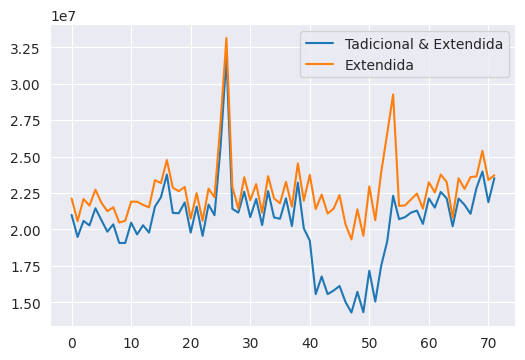

In [104]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tadicional & Extendida', 'Extendida'] )

### H7- Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA** Lojas vendem menos no feriado de Natal

<AxesSubplot:xlabel='year', ylabel='sales'>

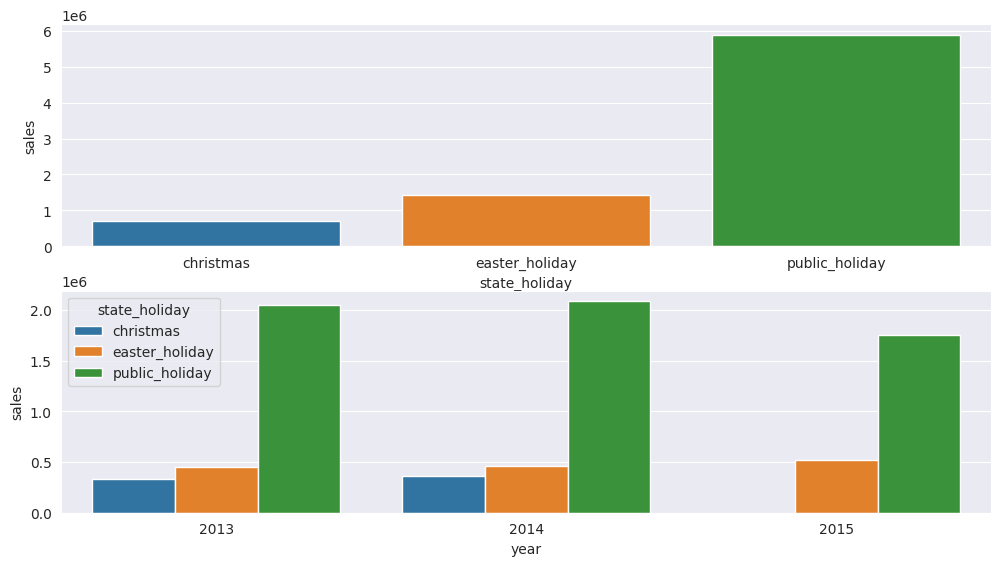

In [121]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(12, 10))
plt.subplot( 3, 1, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 3, 1, 2 )
aux2 = aux[['state_holiday', 'year', 'sales']].groupby( ['state_holiday', 'year'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2  )


### H8 - Lojas deveriam vender mais ao longo dos anos
**FALSO** Lojas vendem menos ao longo dos anos 

<AxesSubplot:>

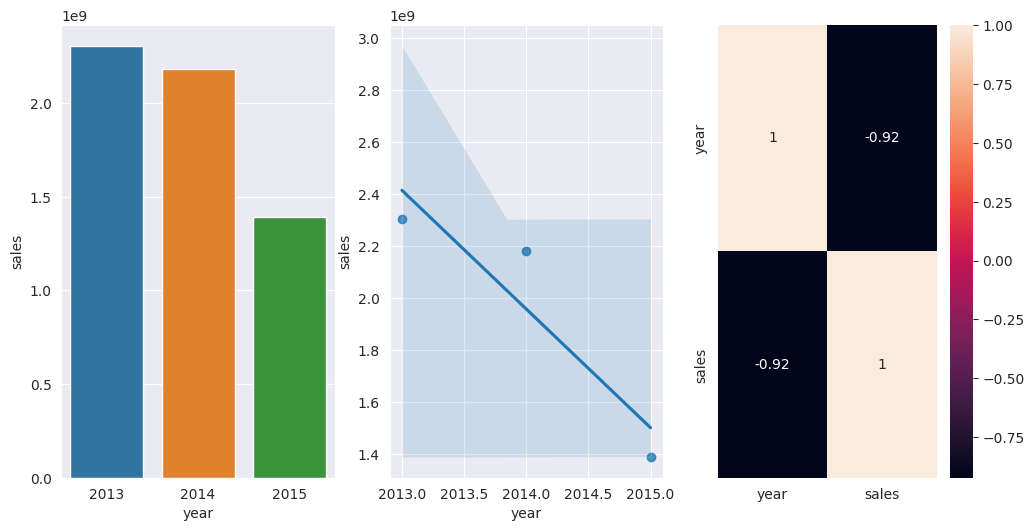

In [130]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.barplot( x='year', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.regplot( x='year', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

### H9- Lojas deveriam vender mais no segundo semestre do ano
**FALSO** Lojas vendem menos no segundo semestre do ano

<AxesSubplot:>

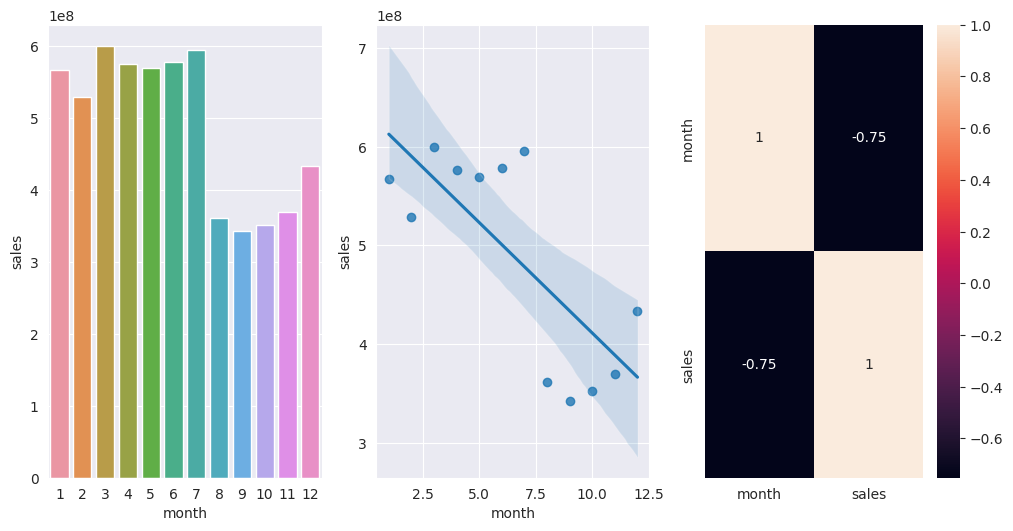

In [131]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.barplot( x='month', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.regplot( x='month', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

### H10- Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRO** Lojas vendem mais depois do décimo dia do mês

<AxesSubplot:xlabel='before_after', ylabel='sales'>

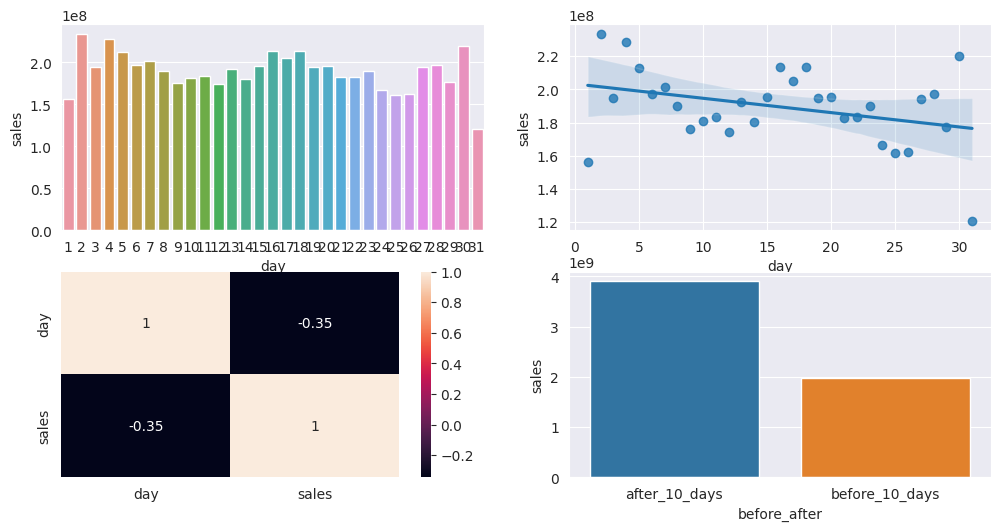

In [136]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.barplot( x='day', y='sales', data=aux1 )

plt.subplot(2, 2, 2)
sns.regplot( x='day', y='sales', data=aux1 )

plt.subplot(2, 2, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True )


plt.subplot(2, 2, 4) 
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2)

### H11. Lojas deveriam vender menos aos finais de semana
**VERDADEIRO** Lojas vendem menos nos finais de semana

<AxesSubplot:>

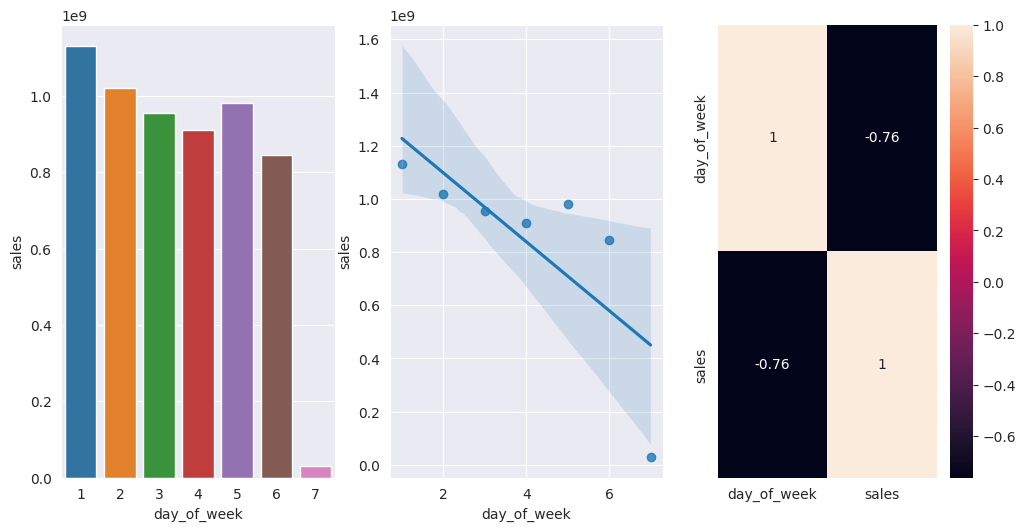

In [139]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

### H12. Lojas deveriam vender menos durante os feriados escolares
**VERDADEIROS** Lojam vendem menos em feriados escolares, exceto em alfuns períodos do ano

<AxesSubplot:xlabel='month', ylabel='sales'>

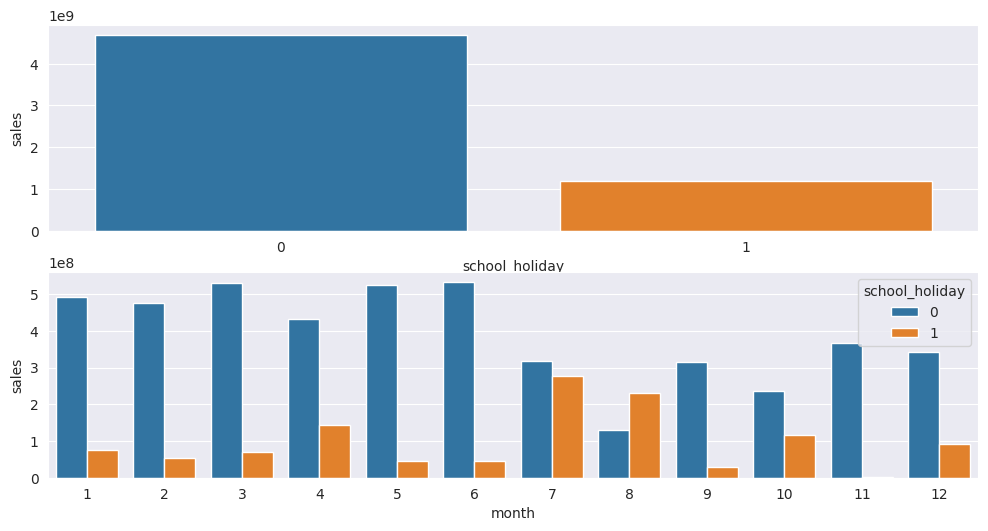

In [146]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux1 )

plt.subplot(2, 1, 2)
aux2 = df4[['school_holiday', 'month', 'sales']].groupby( ['school_holiday', 'month'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 )


## 4.3. Analise Multivariada